In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import math

import warnings
warnings.filterwarnings('ignore')


from sklearn import metrics

from scipy.special import legendre
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import seaborn as sns


In [11]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPRegressor


In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

df = pd.read_csv('all_matches_final.csv')

def preprocess_data(df):
    players = ['Player1_id','Player1_name','Player2_id','Player2_name']
    to_drop = ['tourney_id','tourney_date','score', 'tourney_name']
    cat_cols = ['surface','draw_size','tourney_level','Player1_entry','Player1_hand','Player1_ioc',
                'Player2_entry','Player2_hand','Player2_ioc','best_of','round']
    num_cols = ['match_num','Player1_ht','Player1_age','Player1_rank','Player1_rank_points',
                'Player2_ht','Player2_age','Player2_rank','Player2_rank_points','minutes','w_ace','w_df',
                'w_svpt','w_1stIn','w_1stWon','w_2ndWon','w_SvGms','w_bpSaved','w_bpFaced','l_ace','l_df','l_svpt','l_1stIn',
                'l_1stWon','l_2ndWon','l_SvGms','l_bpSaved','l_bpFaced']

    df = df.drop(to_drop, axis=1)

    for i in cat_cols:
        df[i] = df[i].replace(np.NaN, df[i].mode()[0])

    for i in num_cols:
        if pd.api.types.is_numeric_dtype(df[i]):
            df[i] = df[i].fillna(df[i].mean())

    for col in ['Player1_seed', 'Player2_seed']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df[col].fillna(df[col].mean())

    df = pd.get_dummies(df, columns=cat_cols, prefix_sep='__')

    return df

df_processed = preprocess_data(df)

X = df_processed.drop(['y', 'Player1_name', 'Player2_name'], axis=1)
y = df_processed['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train_scaled, y_train)

y_pred = gb_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

def predict_match(player1, player2):
    print(f"Predicting match between {player1} and {player2}")
    
    player1_data = df[df['Player1_name'] == player1].sort_values('match_num', ascending=False).iloc[0]
    player2_data = df[df['Player2_name'] == player2].sort_values('match_num', ascending=False).iloc[0]
    
    print(f"Found data for {player1}: {player1_data.shape}")
    print(f"Found data for {player2}: {player2_data.shape}")

    match_data = pd.DataFrame(columns=X.columns)
    
    for col in X.columns:
        if col in player1_data.index:
            match_data.loc[0, col] = player1_data[col]
        elif col in player2_data.index:
            match_data.loc[0, col] = player2_data[col]
        else:
            match_data.loc[0, col] = 0
    
    print(f"Prepared match data: {match_data.shape}")
    
    match_data_scaled = scaler.transform(match_data)
    
    print(f"Scaled match data: {match_data_scaled.shape}")
    
    prediction = gb_model.predict(match_data_scaled)
    probability = gb_model.predict_proba(match_data_scaled)
    
    return prediction[0], probability[0]


Model Accuracy: 0.9388

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1168
           1       0.93      0.94      0.94      1135

    accuracy                           0.94      2303
   macro avg       0.94      0.94      0.94      2303
weighted avg       0.94      0.94      0.94      2303



In [34]:
player1 = "Carlos Alcaraz"
player2 = "Rafael Nadal"

try:
    prediction, probability = predict_match(player1, player2)
    if prediction == 1:
        print(f"\n{player1} is predicted to win against {player2}")
    else:
        print(f"\n{player2} is predicted to win against {player1}")
    print(f"Probability: {probability.max():.2f}")
except Exception as e:
    print(f"An error occurred: {str(e)}")
    print("Please check if the player names are correct and exist in the dataset.")


Predicting match between Carlos Alcaraz and Rafael Nadal
Found data for Carlos Alcaraz: (52,)
Found data for Rafael Nadal: (52,)
Prepared match data: (1, 254)
Scaled match data: (1, 254)

Carlos Alcaraz is predicted to win against Rafael Nadal
Probability: 0.63


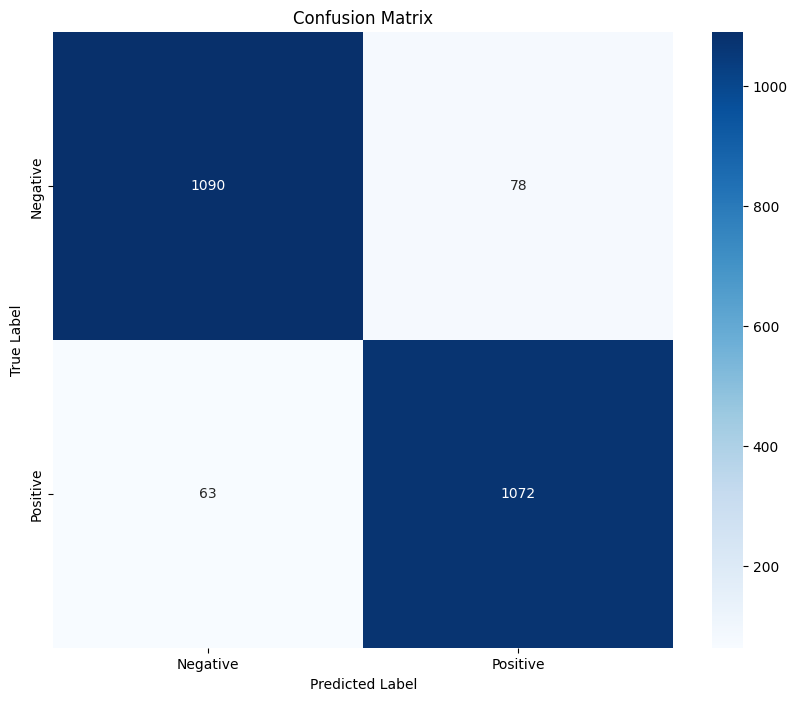

In [35]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)

# Create a plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Customize the plot
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
plt.yticks([0.5, 1.5], ['Negative', 'Positive'])

# Show the plot
plt.show()


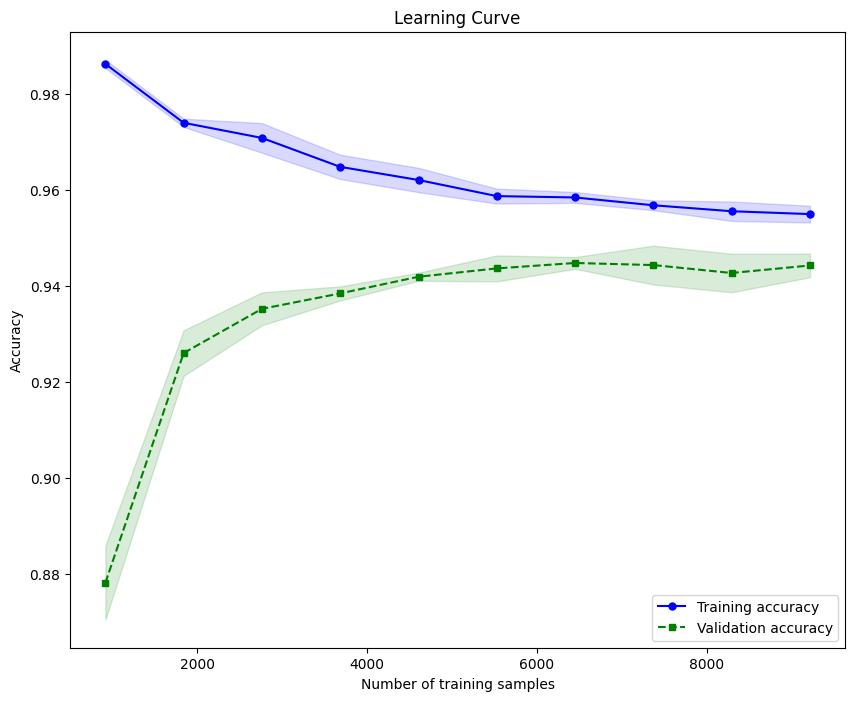

In [36]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    gb_model, X, y, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 8))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc='lower right')
plt.show()
